In [2]:
! pip install -r requirements.txt --quiet

In [1]:
from semantic_kernel import Kernel
from semantic_kernel.kernel import KernelArguments
from semantic_kernel.agents import ChatCompletionAgent,ChatHistoryAgentThread 
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion, OpenAIPromptExecutionSettings 
from semantic_kernel.connectors.ai.azure_ai_inference import AzureAIInferenceChatCompletion
from semantic_kernel.contents import ChatHistory, ChatMessageContent, ImageContent, TextContent
import cv2
from utils import encode_image, fill_prompt, parse_damage_json, draw_damage_boxes,build_damage_chat_with_image_examples, load_example_pairs
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from os import environ
import json

load_dotenv(override=True)

True

In [2]:
before_image = "../../data/transformed/truck_3_orig.jpg"
after_image = "../../data/transformed/truck_3_damage.png"


img = cv2.imread(after_image)
img_height, img_width = img.shape[:2]

print(f"Image dimensions: {img_width}px width x {img_height}px height")

Image dimensions: 1536px width x 1024px height


In [3]:
execution_settings = OpenAIPromptExecutionSettings(service_id="detect")
execution_settings.temperature = 0.2
execution_settings.top_p = .5
execution_settings.seed = 42

In [4]:

kernel = Kernel()

kernel.add_service(AzureChatCompletion(
    service_id="detect",
    deployment_name=environ["AZURE_OPENAI_CHAT_MODEL"],
    endpoint=environ["AZURE_OPENAI_ENDPOINT"],
    api_key=environ["AZURE_OPENAI_API_KEY"]
    ))


In [5]:
instructions = """
You are a vehicle damage detection expert. Compare the two provided images
to identify any visible physical damage such as dents, scratches, cracks, or deformations.
Ignore lighting changes, reflections, and background differences.

Return ONLY a valid JSON object using double quotes for all keys and string values.
Do NOT include markdown, code blocks, or explanations outside of the JSON.

Use the following format:

{
    "damage_summary": "<summary of all observed damage>",
    "damage_locations": [
        {
            "type": "<dent|scratch|crack|other>",
            "severity": "<low|medium|high>",
            "bounding_box": {
                "x_min": <int>,  # left edge in pixels
                "y_min": <int>,  # top edge in pixels
                "x_max": <int>,  # right edge in pixels
                "y_max": <int>   # bottom edge in pixels
            },
            "confidence": <float 0-1>  # confidence level
        }
    ]
}

Notes:
- Use pixel coordinates relative to the AFTER image (the second image provided).
- The origin (0,0) is the top-left corner of the image.
- All bounding boxes must tightly enclose visible damage.
- The output image resolution is 1536×1024 pixels unless otherwise specified.
- Use integers for coordinates and floating-point values for confidence (0–1 range).
- Return only true physical damage, not reflections or shadows.
- Use only double quotes so the JSON can be parsed directly in Python.
- Vehicles can have multiple damage types; list each in the damage_locations array.
"""




In [6]:


chat_history = build_damage_chat_with_image_examples(
    before_image, after_image, img_width, img_height, load_example_pairs()
)

In [ ]:
# for message in chat_history.messages:
#     print(message.content)
#     for images in message.items:
#         if isinstance(images, ImageContent):
#             print(f"  Image: {images.uri}")

Example 1:
Here are BEFORE and AFTER images of a damaged vehicle.
Each image is 1536px wide and 1024px tall.
Below is the correct analysis JSON for this pair:

{
  "damage_summary": "Dent driver side hood and scratches on driver side door and rear fender.",
  "damage_locations": [
    {
      "type": "dent",
      "severity": "medium",
      "confidence": 0.9,
      "bounding_box": {
        "x_min": 453,
        "y_min": 470,
        "x_max": 595,
        "y_max": 544
      }
    },
    {
      "type": "scratch",
      "severity": "medium",
      "confidence": 0.85,
      "bounding_box": {
        "x_min": 759,
        "y_min": 501,
        "x_max": 908,
        "y_max": 616
      }
    },
    {
      "type": "scratch",
      "severity": "medium",
      "confidence": 0.8,
      "bounding_box": {
        "x_min": 1010,
        "y_min": 408,
        "x_max": 1104,
        "y_max": 507
      }
    }
  ]
}
  Image: ..\..\data\transformed\truck_2_orig.jpg
  Image: ..\..\data\transformed\tr

In [8]:

agent = ChatCompletionAgent(
    kernel=kernel, 
    name="DamageDetectionAgent",
    instructions=instructions,
    arguments=KernelArguments(settings=execution_settings)
)

detection_result = await agent.get_response(chat_history )

print(detection_result)

{
  "damage_summary": "Large dent and scratches on passenger side door and lower panel area.",
  "damage_locations": [
    {
      "type": "dent",
      "severity": "high",
      "confidence": 0.95,
      "bounding_box": {
        "x_min": 720,
        "y_min": 520,
        "x_max": 950,
        "y_max": 670
      }
    },
    {
      "type": "scratch",
      "severity": "medium",
      "confidence": 0.9,
      "bounding_box": {
        "x_min": 650,
        "y_min": 640,
        "x_max": 1000,
        "y_max": 700
      }
    }
  ]
}


In [9]:
damage_data = parse_damage_json(str(detection_result))

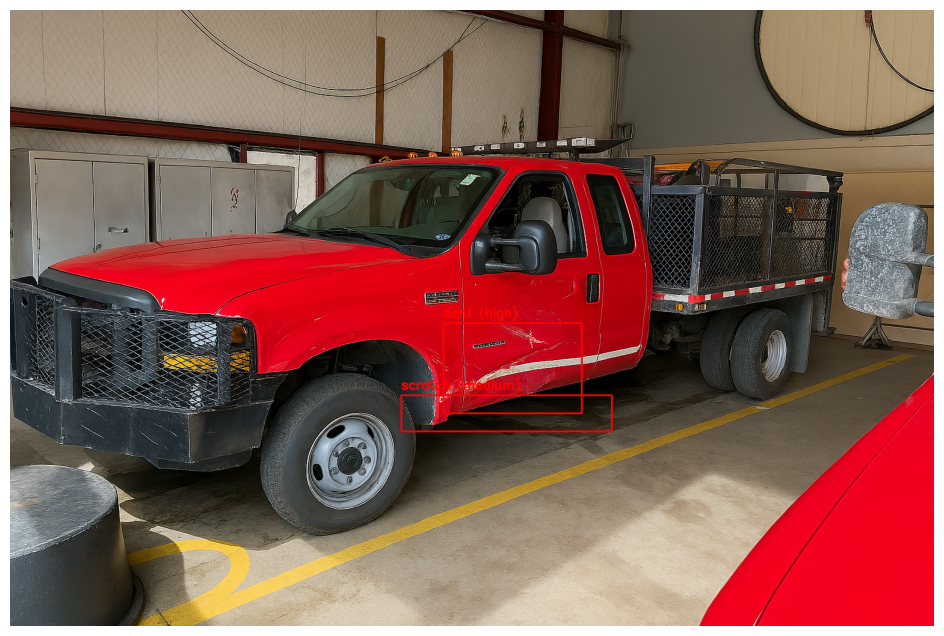

In [10]:
img_with_boxes = draw_damage_boxes(after_image, damage_data)

plt.figure(figsize=(12, 8))
plt.imshow(img_with_boxes)
plt.axis("off")
plt.show()